<a href="https://colab.research.google.com/github/andreianmatos/temporal_spaces_texture_gen/blob/main/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from IPython import display
import requests
from io import BytesIO
from zipfile import ZipFile
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from google.colab import drive

Get the original dataset to augment.

In [2]:
dataset_link = 'https://github.com/andreianmatos/temporal_spaces_texture_gen/raw/main/datasets/captures.zip'

# Fetch the zip file content
response = requests.get(dataset_link)
zip_data = BytesIO(response.content)

# Extract the contents of the zip file
with ZipFile(zip_data, 'r') as zip_ref:
    zip_ref.extractall()

dataset_path = 'captures'

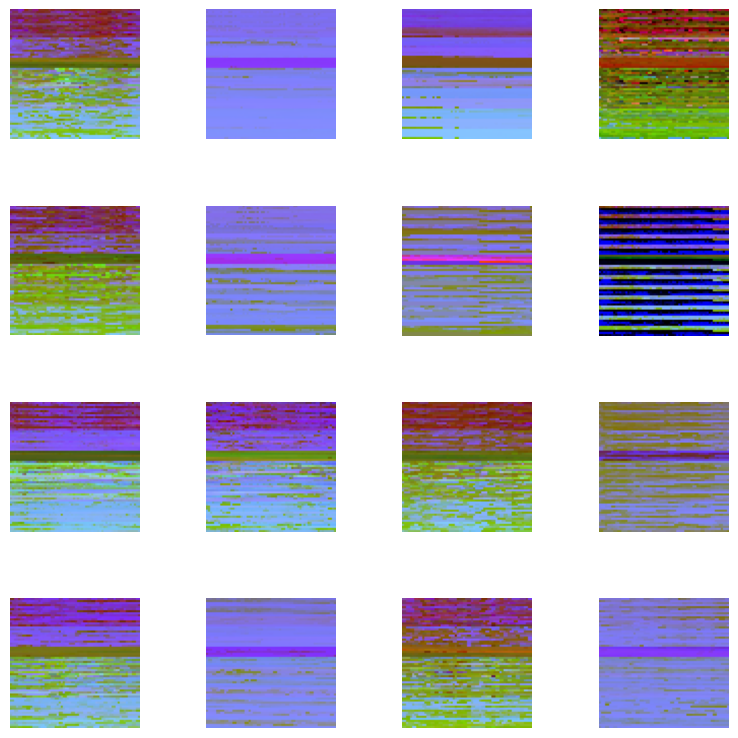

In [3]:
# Define the path to your dataset
image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('.png')]

images = []
# Loop through each image file and load the image
for image_file in image_files:
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Normalize pixel values to the range [0, 1] and save as float32
    image = image.astype(np.float32) / 255.0
    images.append(image)

train_images = np.array(images, dtype=np.float32)

np.save('preprocessed_train_images.npy', train_images)

# Display images in a grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(train_images[i * 4 + j])
        axs[i, j].axis('off')

plt.show()

In [4]:
train_images, test_images = train_test_split(train_images, test_size=0.2, random_state=42)

np.save('preprocessed_train_split_images.npy', train_images)
np.save('preprocessed_test_split_images.npy', test_images)

## Add a channel dimension if it doesn't exist
if len(train_images.shape) == 3:
    train_images = train_images[..., tf.newaxis]
if len(test_images.shape) == 3:
    test_images = test_images[..., tf.newaxis]

Apply the data augmentation, the more times, the larger dataset.

Apply only to train set...

In [5]:
def apply_data_augmentation(image):
    # horizontal flip
    image = tf.image.random_flip_left_right(image)
    # vertical flip
    image = tf.image.random_flip_up_down(image)
    # brightness
    image = tf.image.random_brightness(image, max_delta=0.2)
    # contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0.0, 1.0)

    return image

New dataset size: 39600


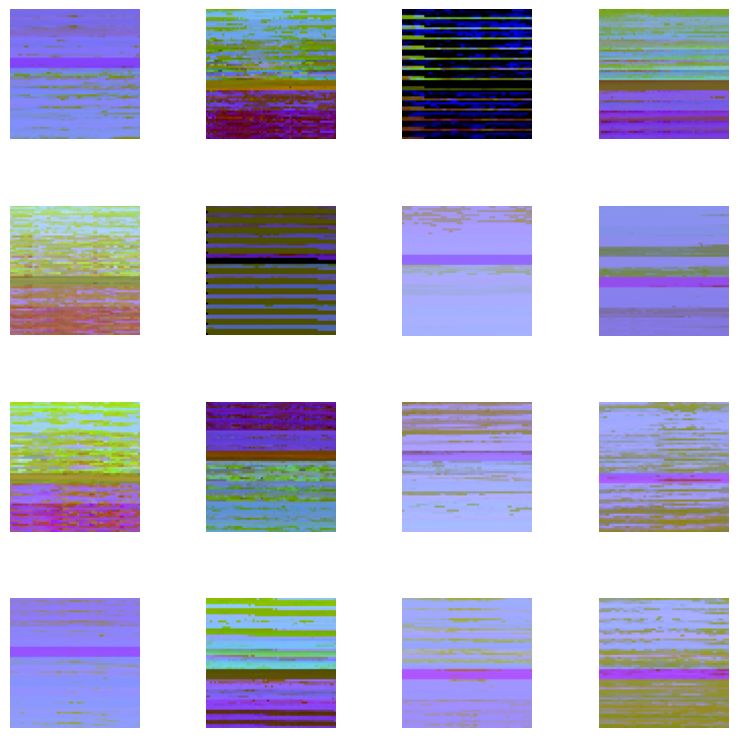

In [6]:
num_repeats = 50

augmented_train_images = []
for _ in range(num_repeats):
    augmented_images = np.array([apply_data_augmentation(image) for image in train_images], dtype=np.float32)
    augmented_train_images.extend(augmented_images)

print("New dataset size:",len(augmented_train_images))

# Display images in a grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(augmented_train_images[i * 4 + j])
        axs[i, j].axis('off')

plt.show()

Save augmented dataset to a folder in Google Drive.

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
output_folder = '/content/drive/MyDrive/Augmented_Images/train_set'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save each image in the output folder
for i, image in enumerate(augmented_train_images):
    plt.imsave(os.path.join(output_folder, f'augmented_image_{i}.png'), image)

In [10]:
output_folder = '/content/drive/MyDrive/Augmented_Images/test_set'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save each image in the output folder
for i, image in enumerate(test_images):
    plt.imsave(os.path.join(output_folder, f'test_set_image_{i}.png'), image)